Ответы вынесены сюда, результаты внизу.

Для оценки того, какой классификатор справился лучше, решил добавить среднюю оценку кроссвалидации и разброс оценок.
На самом деле не понимаю, как при использовании кросс-валидации оценить лучшую модель без оценки этих показателей.

Модели оптимизировались по roc_auc_score. Очевидно, что модель XGBoost, показавшая в этой оценке лучший результат, может быть признана лучшей. На втором месте модель AdaBoost.

Если интерпретировать оценку по кроссвалидации, видно, что XGBoost более устойчив к изменениям данных (меньший разброс оценок на разных фолдах).

Также модели XGBoost и AdaBoost имеют практически равный и самый высокий в группе F1-score, что свидетельствует о лучших одновременно оценках percision и recall в исследуемой группе. На текущей выборке оценка по percision у AdaBoost  выше - модель точнее классифицирует объекты. Оценка по recall выше у XGBoost, что говорит, что модель лучше "узнаёт" нулевой класс. 

### Опциональный вопрос
Модель в первом и втором случае даёт высокие метрики по полноте (и TPR), т.к. практически все объекты первого класса выбраны, как первый класс, т.е. "узнаны". 
Первая модель при оценке прецизионности (percision) даст высокие результаты. Точно также хорошие результаты будут по FPR, ведь модель почти не ошиблась.
Вторая модель при оценке percision даст низкие результаты, т.к. будет высокое значение FP. Но значения FPR "просядут" не сильно, т.к. не учитывают количество верно названных объектов P класса. Отсюда можно подобрать ситуацию, когда на "плохом" классификаторе и сильно несбалансированном классе мы можем получить "хороший" roc auc, но "плохо" pr auc. 
Вообще лучше использовать пару метрик, т.к. одну можно "ввести в заблуждение" удачно подобранным ранжированием.

Во втором случае как P выбрано 1000 объектов, при этом TP = 90. 910 объектов не верно отнесено к P классу, т.е. FN = 910, отсюда 98980 были верно отнесены к N классу, т.е. TN = 98980, ещё N - TN объектов модель не верно записала в P, т.е. FP - 910.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [3]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("train_case2.csv", sep=';')
df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
df['ap_hi'].value_counts()

120     27699
140      9506
130      8961
110      8644
150      4450
        ...  
97          1
230         1
806         1
2000        1
93          1
Name: ap_hi, Length: 153, dtype: int64

Смотрим на данные

In [7]:
def draw_graphics(train, col, hist = False):
    """
    
    """
    fig, ax = plt.subplots(1,3,figsize=(20,7))
    ax[1].set_title('Train Dataset')
    # ax[2].set_title('Test Dataset')
    sns.distplot(train[col], color='r', ax=ax[0], hist=hist, label='Train')
    #sns.distplot(test[col], color='b', ax=ax[0], hist=hist, label='Test', kde_kws={'linestyle':'--'})
    sns.boxplot(train[col], color='orange', ax=ax[1])
    #sns.boxplot(test[col], color='g', ax=ax[2])
    plt.show()


In [8]:
# continuous_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
# for col in continuous_cols:
#     draw_graphics(df, col)

In [11]:
# for col in df:
#     if col not in continuous_cols:
#         draw_graphics(df, col, True)

In [12]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
df.loc[df['cardio'] == 1]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
15,24,16782,2,172,112.0,120,80,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,99991,19699,1,172,70.0,130,90,1,1,0,0,1,1
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


35021


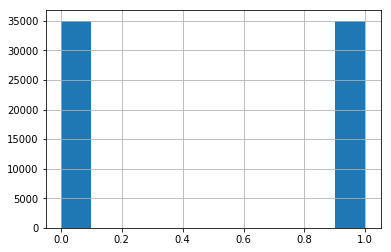

In [15]:
df['cardio'].hist()
print(len(df) - len(df.loc[df['cardio'] == 1]))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027830B978D0>,
      dtype=object)

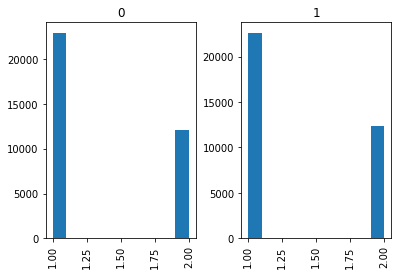

In [16]:
df['gender'].hist(by=df['cardio'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=84)

In [18]:
from sklearn.pipeline import FeatureUnion
import itertools
from sklearn.metrics import roc_auc_score, log_loss

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-0.2085371 ,  0.68693194,  0.40208326, ...,  0.        ,
         0.        ,  1.        ],
       [-1.34236915,  0.32150435, -0.63949563, ...,  0.        ,
         0.        ,  0.        ],
       [-1.07665896,  0.32150435,  1.51310073, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [-0.53144598, -0.04392324, -0.63949563, ...,  0.        ,
         0.        ,  1.        ],
       [-0.51359675, -0.77477841, -1.12556577, ...,  0.        ,
         0.        ,  0.        ],
       [-1.37644497,  0.07788596, -0.36174126, ...,  0.        ,
         0.        ,  1.        ]])

Сначала как в лекции

In [19]:
def predictor(pipeline, predictor_name):
    print('*'*70)
    print(f"Обрабатываем {predictor_name}")
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print('CV score is {}+-{}'.format(cv_score, cv_score_std))

    #обучим пайплайн на всем тренировочном датасете
    b = 1 # F-score параметр
    pipeline.fit(X_train, y_train)
    y_score = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ix=%d' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix],
                                                                                  ix))
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC curve')
    #plt.savefig("ROC.png")
    plt.show()
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                          title='Confusion matrix')
    # plt.savefig("conf_matrix.png")
    plt.show()
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    print(f"TPR={TPR}, FPR={FPR}, TNR={TNR}")
    roc_auc_score_ = roc_auc_score(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:,1])
    log_loss_score_ = log_loss(y_true=y_test, y_pred=pipeline.predict_proba(X_test)[:,1])
    print("roc auc score: {}".format(roc_auc_score_))
    print("log loss score: {}".format(log_loss_score_))
    print('*'*70)
    return predictor_name, precision[ix], recall[ix], fscore[ix], roc_auc_score_, log_loss_score_, cv_score, cv_score_std

In [20]:
res = []

**********************************************************************
Обрабатываем LogisticRegression
CV score is 0.7892031497609102+-0.004001490289456665
Best Threshold=0.395406, F-Score=0.736, Precision=0.669, Recall=0.819, ix=6777


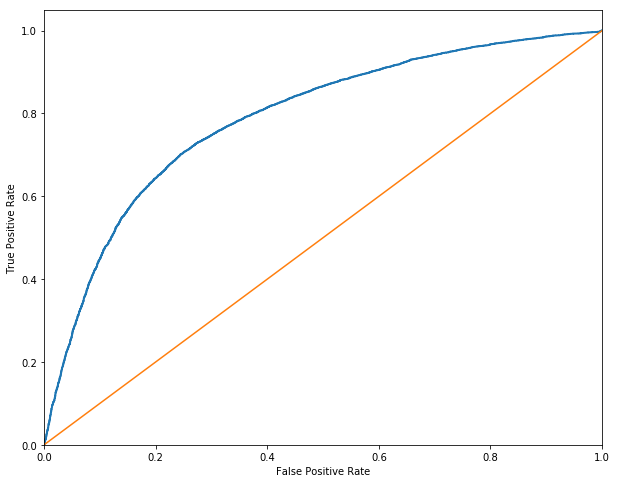

Confusion matrix, without normalization
[[5191 3549]
 [1589 7171]]


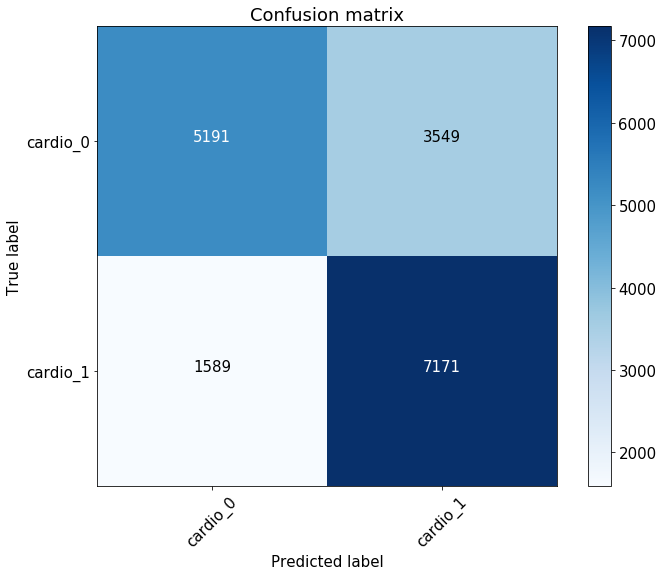

TPR=0.818607305936073, FPR=0.40606407322654464, TNR=0.5939359267734554
roc auc score: 0.787229573524341
log loss score: 0.5778741652385997
**********************************************************************


In [21]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 84)),
])
res.append(predictor(classifier, "LogisticRegression"))

Используем RandomForest

In [22]:
from sklearn.ensemble import RandomForestClassifier

**********************************************************************
Обрабатываем RandomForest
CV score is 0.7738613190679737+-0.005600557294278627
Best Threshold=0.360000, F-Score=0.720, Precision=0.647, Recall=0.811, ix=69


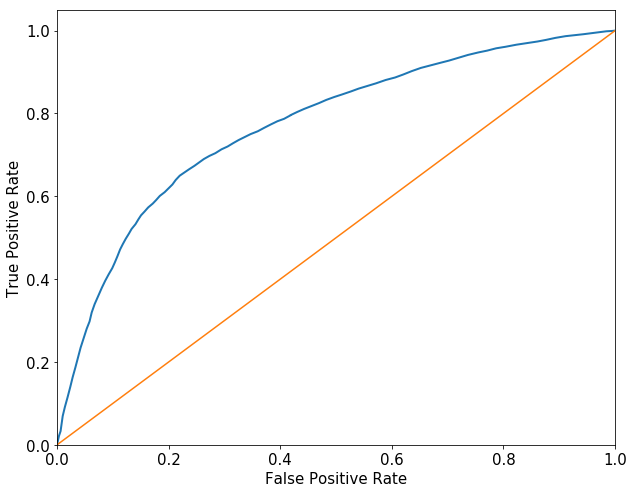

Confusion matrix, without normalization
[[4978 3762]
 [1720 7040]]


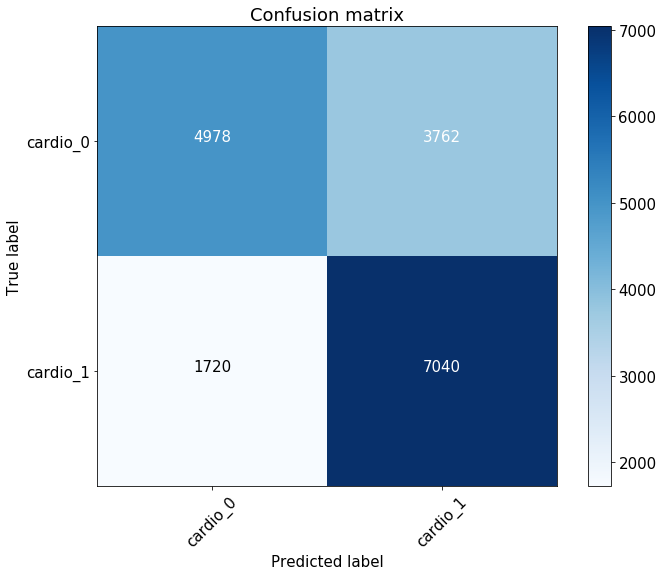

TPR=0.8036529680365296, FPR=0.43043478260869567, TNR=0.5695652173913044
roc auc score: 0.7713960312111428
log loss score: 0.60685424200161
**********************************************************************


In [23]:
classifier = Pipeline([
    ('features',feats),
    ('RandomForestClassifier', RandomForestClassifier(n_jobs=-1, random_state=42))
])
res.append(predictor(classifier, "RandomForest"))

Используем XGBoost

In [24]:
import xgboost as xgb

**********************************************************************
Обрабатываем XGBoost
CV score is 0.7964623924017232+-0.003989655961825579
Best Threshold=0.352028, F-Score=0.740, Precision=0.669, Recall=0.828, ix=6220


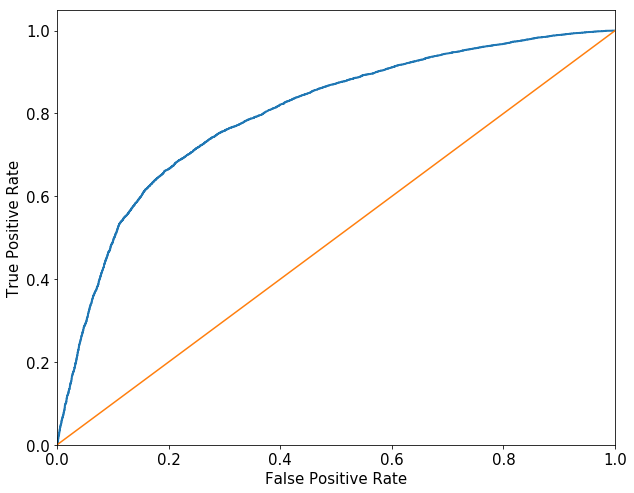

Confusion matrix, without normalization
[[5154 3586]
 [1505 7255]]


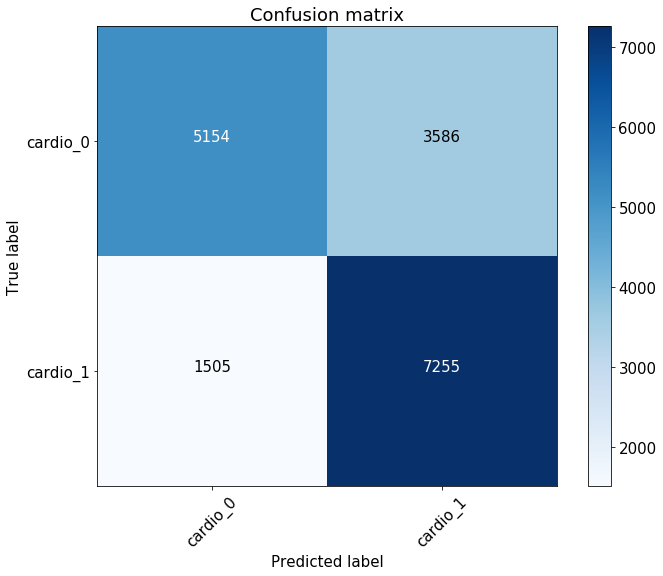

TPR=0.8281963470319634, FPR=0.4102974828375286, TNR=0.5897025171624714
roc auc score: 0.7974589223953272
log loss score: 0.5474615536548996
**********************************************************************


In [25]:
classifier = Pipeline([
    ('features',feats),
    ('xgb', xgb.XGBClassifier(n_jobs=-1, random_state=42))
])
res.append(predictor(classifier, "XGBoost"))

Используем AdaBoost

In [26]:
from sklearn.ensemble import AdaBoostClassifier

**********************************************************************
Обрабатываем AdaBoost
CV score is 0.7955713908267044+-0.004278436564289018
Best Threshold=0.497234, F-Score=0.740, Precision=0.691, Recall=0.797, ix=1754


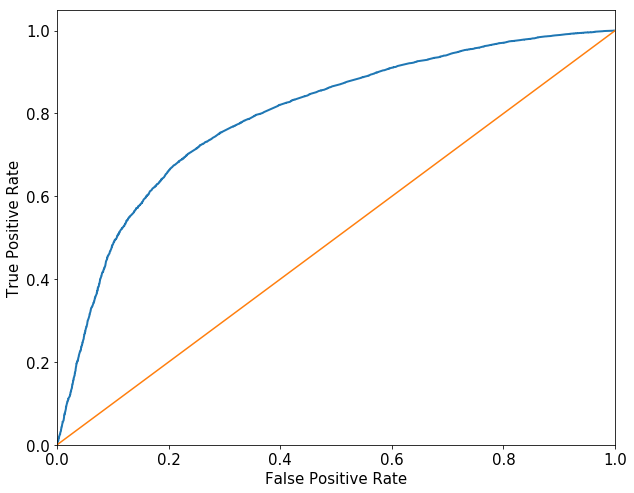

Confusion matrix, without normalization
[[5625 3115]
 [1783 6977]]


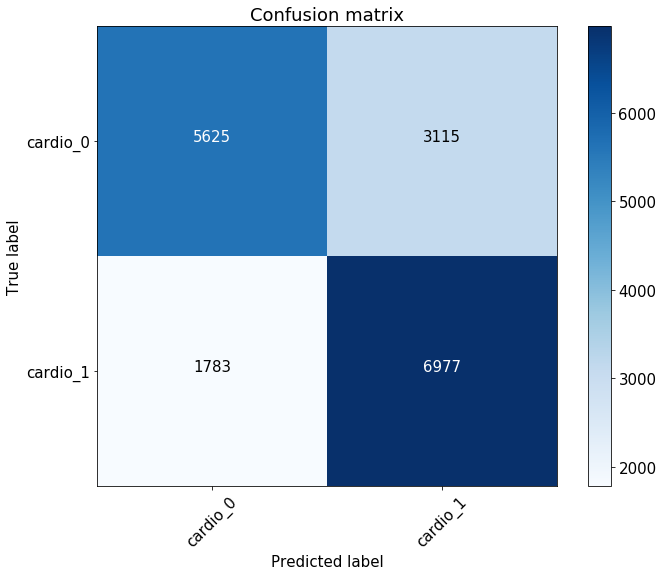

TPR=0.7964611872146119, FPR=0.35640732265446223, TNR=0.6435926773455377
roc auc score: 0.793838783789432
log loss score: 0.6869030120729114
**********************************************************************


In [27]:
classifier = Pipeline([
    ('features',feats),
    ('ada', AdaBoostClassifier(random_state=42))
])
res.append(predictor(classifier, "AdaBoost"))

In [28]:
columns=['classifier', 'precision', 'recall', 'f_score', 'roc_auc_score', 'log_loss_score', 'cv_mean', 'cv_std']
result = pd.DataFrame(res, columns=columns)
result


,classifier,precision,recall,f_score,roc_auc_score,log_loss_score,cv_mean,cv_std
0,LogisticRegression,0.668967,0.818721,0.736307,0.787230,0.577874,0.789203,0.004001
1,RandomForest,0.647434,0.810845,0.719984,0.771396,0.606854,0.773861,0.005601
2,XGBoost,0.669249,0.828311,0.740333,0.797459,0.547462,0.796462,0.003990
3,AdaBoost,0.691370,0.796575,0.740254,0.793839,0.686903,0.795571,0.004278


Для оценки того, какой классификатор справился лучше, решил добавить среднюю оценку кроссвалидации и разброс оценок.
На самом деле не понимаю, как при использовании кросс-валидации оценить лучшую модель без оценки этих показателей.

Модели оптимизировались по roc_auc_score. Очевидно, что модель XGBoost, показавшая в этой оценке лучший результат, может быть признана лучшей. На втором месте модель AdaBoost.

Если интерпретировать оценку по кроссвалидации, видно, что XGBoost более устойчив к изменениям данных (меньший разброс оценок на разных фолдах).

Также модели XGBoost и AdaBoost имеют практически равный и самый высокий в группе F1-score, что свидетельствует о лучших одновременно оценках percision и recall в исследуемой группе. На текущей выборке оценка по percision у AdaBoost  выше - модель точнее классифицирует объекты. Оценка по recall выше у XGBoost, что говорит, что модель лучше "узнаёт" нулевой класс. 

Оценка roc auc показывает, с какой вероятностью случайно взятый true элемент будет расположен правее (или выше) случайно взятого false элемента, т.е. то, как хорошо модель ранжирует случайный true элемент относительно false элемента. Понятнее объяснить не получилось, скорее всего, не понял, как это применяется на практике кроме того, что "roc auc выше, значит модель лучше".

### Опциональный вопрос
Модель в первом и втором случае даёт высокие метрики по полноте (и TPR), т.к. практически все объекты первого класса выбраны, как первый класс, т.е. "узнаны". 
Первая модель при оценке прецизионности (percision) даст высокие результаты. Точно также хорошие результаты будут по FPR, ведь модель почти не ошиблась.
Вторая модель при оценке percision даст низкие результаты, т.к. будет высокое значение FP. Но значения FPR "просядут" не сильно, т.к. не учитывают количество верно названных объектов P класса. Отсюда можно подобрать ситуацию, когда на "плохом" классификаторе и сильно несбалансированном классе мы можем получить "хороший" roc auc, но "плохо" pr auc. 
Вообще лучше использовать пару метрик, т.к. одну можно "ввести в заблуждение" удачно подобранным ранжированием.